In [1]:
#https://towardsdatascience.com/this-tutorial-will-make-your-api-data-pull-so-much-easier-9ab4c35f9af
#https://dev.to/m0nica/how-to-use-the-tmdb-api-to-find-films-with-the-highest-revenue-82p

In [669]:
import config # to hide TMDB API keys
import requests # to make TMDB API calls
import locale # to format currency as USD
locale.setlocale( locale.LC_ALL, '' )

import pandas as pd
#import matplotlib
import matplotlib.pyplot as plt
#from matplotlib.ticker import FuncFormatter # to format currency on charts axis

import itertools
from pandas import json_normalize 
import networkx as nx
import datetime

api_key = config.tmdb_api_key # get TMDB API key from config.py file


In [670]:
#Test API by pulling full credits for "Dune"
query = "https://api.themoviedb.org/3/movie/" + "438631" + "/credits?api_key=" + api_key + "&language=en-US"
response =  requests.get(query)
array = response.json()

In [671]:
#Get full cast and put into a pandas DF
temp_cast = json_normalize(array, 'cast')

In [672]:
temp_cast.head()

,adult,gender,id,known_for_department,name,original_name,popularity,profile_path,cast_id,character,credit_id,order
0,False,2,1190668,Acting,Timothée Chalamet,Timothée Chalamet,43.555,/i31xZ0qcki624t1y76fPGlQPVgI.jpg,13,Paul Atreides,5b4d01bac3a36823d803cd45,0
1,False,1,933238,Acting,Rebecca Ferguson,Rebecca Ferguson,50.061,/6NRlV9oUipeak7r00V6k73Jb7we.jpg,14,Lady Jessica Atreides,5b90742fc3a368222e002f41,1
2,False,2,25072,Acting,Oscar Isaac,Oscar Isaac,26.354,/dW5U5yrIIPmMjRThR9KT2xH6nTz.jpg,53,Duke Leto Atreides,5c50bc070e0a2612cccedcb3,2
3,False,2,16851,Acting,Josh Brolin,Josh Brolin,31.119,/sX2etBbIkxRaCsATyw5ZpOVMPTD.jpg,73,Gurney Halleck,5c64750d9251412fb4feec3e,3
4,False,2,1640,Acting,Stellan Skarsgård,Stellan Skarsgård,14.218,/x78BtYHElirO7Iw8bL4m8CnzRDc.jpg,31,Baron Vladimir Harkonnen,5c364b61c3a368273c1c5fee,4


In [673]:
#Turn dataframe into a dyadic dataset that we can turn into a graph
dyads_cast = pd.DataFrame(list(itertools.combinations(temp_cast['name'], 2)))
dyads_cast = dyads_cast.drop_duplicates()
dyads_cast.columns = ['source','target']

In [674]:
#Turn df into graph using NetworkX
G = nx.from_pandas_edgelist(dyads_cast, 'source', 'target')
pos = nx.spring_layout(G)

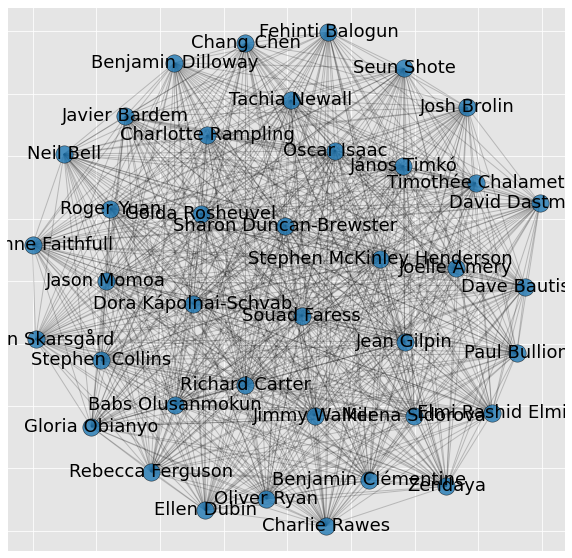

In [675]:
f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')

nodes = nx.draw_networkx_nodes(G, pos,
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(G, pos, font_size=18)

nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)

In [712]:
movies = pd.read_csv("oscars.csv")
#There is no data for the movie Ascension so I exclude to avoid errors later
movies = movies.loc[movies['original_title'] != "Ascension"]

In [677]:
#Create empty DataFrames to append to
full_cast_df = pd.DataFrame()
full_crew_df = pd.DataFrame()

#Loop through movie list
for index, row in movies.iterrows():
    movie_id = row['id']
    #Query TMDB for cast and crew for movie
    query = "https://api.themoviedb.org/3/movie/" + str(movie_id) + "/credits?api_key=" + api_key + "&language=en-US"
    response =  requests.get(query)
    if response.status_code==200: 
    #status code ==200 indicates the API query was successful
        array = response.json()
        title = row['original_title']
        #Create DataFrames for this movies cast and crew lists
        temp_cast = json_normalize(array, 'cast')
        temp_crew = json_normalize(array, 'crew')
        #Create a new column called 'movie' where we put the title of the movie
        temp_cast = temp_cast.assign(movie=title)
        temp_crew = temp_crew.assign(movie=title)
        
        #Append individual movies cast and crew list to the main dataframe so we have one with all of them
        full_cast_df = pd.concat([full_cast_df, temp_cast])
        full_crew_df = pd.concat([full_crew_df, temp_crew])

In [678]:
fullCastAndCrewDF = pd.concat([full_cast_df,full_crew_df])

In [679]:
def getRole(x):
    if pd.isnull(x['character']) == True:
        return(x['movie'] + ": " + x['job'])
    else:
        return(x['movie'] + ": " + "Actor " + x['character'])

In [680]:
fullCastAndCrewDF['role'] = fullCastAndCrewDF.apply(lambda x: getRole(x), axis = 1)

In [681]:
pd.DataFrame(fullCastAndCrewDF.groupby('movie')['name'].count()).sort_values(by='name',ascending=False).head()

,name
movie,
CODA,341
Licorice Pizza,230
tick tick BOOM!,206
Dune,205
Don't Look Up,188


In [682]:
prolifics = fullCastAndCrewDF.groupby(['name']).agg({'movie':lambda x: list(x), 'role':lambda x: list(x)})
prolifics['freq'] = prolifics['movie'].apply(lambda x: len(x))
pd.set_option("display.max_colwidth", -1)
prolifics.sort_values('freq',ascending=False).head(10)

<ipython-input-682-af13ef68540f>:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


,movie,role,freq
name,,,
Lin-Manuel Miranda,"[tick tick BOOM!, Summer of Soul, tick tick BOOM!, tick tick BOOM!, Encanto, Encanto]","[tick tick BOOM!: Actor Diner Manager (uncredited), Summer of Soul: Actor Self, tick tick BOOM!: Director, tick tick BOOM!: Producer, Encanto: Original Music Composer, Encanto: Songs]",6
Christopher Scarabosio,"[Don't Look Up, Licorice Pizza, Luca, Luca, Luca]","[Don't Look Up: Supervising Sound Editor, Licorice Pizza: Supervising Sound Editor, Luca: Sound Designer, Luca: Supervising Sound Editor, Luca: Sound Re-Recording Mixer]",5
Jonathan Larson,"[tick tick BOOM!, tick tick BOOM!, tick tick BOOM!, tick tick BOOM!]","[tick tick BOOM!: Actor Self (archive footage) (uncredited), tick tick BOOM!: Author, tick tick BOOM!: Music, tick tick BOOM!: Musical]",4
Joel Coen,"[The Tragedy of Macbeth, The Tragedy of Macbeth, The Tragedy of Macbeth, The Tragedy of Macbeth]","[The Tragedy of Macbeth: Screenplay, The Tragedy of Macbeth: Director, The Tragedy of Macbeth: Editor, The Tragedy of Macbeth: Producer]",4
Donald Mowat,"[Dune, Dune, Dune, Dune]","[Dune: Makeup Department Head, Dune: Hair Designer, Dune: Makeup Designer, Dune: Prosthetic Designer]",4
Adam McKay,"[Don't Look Up, Don't Look Up, Don't Look Up, Don't Look Up]","[Don't Look Up: Screenplay, Don't Look Up: Director, Don't Look Up: Producer, Don't Look Up: Story]",4
Paul Thomas Anderson,"[Licorice Pizza, Licorice Pizza, Licorice Pizza, Licorice Pizza]","[Licorice Pizza: Screenplay, Licorice Pizza: Director, Licorice Pizza: Director of Photography, Licorice Pizza: Producer]",4
Hans Zimmer,"[Dune, Dune, No Time to Die]","[Dune: Original Music Composer, Dune: Music Producer, No Time to Die: Original Music Composer]",3
Eddie Murphy,"[Coming 2 America, Coming 2 America, Coming 2 America]","[Coming 2 America: Actor Prince Akeem / Clarence / Saul / Randy Watson, Coming 2 America: Producer, Coming 2 America: Characters]",3


In [683]:
fullCastAndCrewDF_noDupes = fullCastAndCrewDF.drop_duplicates(['name','movie'])
prolifics2 = fullCastAndCrewDF_noDupes.groupby(['name']).agg({'movie':lambda x: list(x), 'role':lambda x: list(x)})
prolifics2['freq'] = prolifics2['movie'].apply(lambda x: len(x))
pd.set_option("display.max_colwidth", -1)
prolifics2.sort_values('freq',ascending=False).head(15)

<ipython-input-683-44427209c877>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


,movie,role,freq
name,,,
Francine Maisler,"[Don't Look Up, Dune, Being the Ricardos]","[Don't Look Up: Casting, Dune: Casting, Being the Ricardos: Casting]",3
Maya Rudolph,"[Licorice Pizza, Luca, The Mitchells vs the Machines]","[Licorice Pizza: Actor Gale, Luca: Actor Daniela Paguro (voice), The Mitchells vs the Machines: Actor Linda Mitchell (voice)]",3
Lin-Manuel Miranda,"[tick tick BOOM!, Summer of Soul, Encanto]","[tick tick BOOM!: Actor Diner Manager (uncredited), Summer of Soul: Actor Self, Encanto: Original Music Composer]",3
Justin Doyle,"[Don't Look Up, Encanto, Luca]","[Don't Look Up: Sound Effects Editor, Encanto: Sound Effects Editor, Luca: Sound Effects Editor]",3
Ron Bartlett,"[Dune, King Richard, Cruella]","[Dune: Sound Re-Recording Mixer, King Richard: Sound Re-Recording Mixer, Cruella: Sound Re-Recording Mixer]",3
Jonny Greenwood,"[The Power of the Dog, Licorice Pizza, Spencer]","[The Power of the Dog: Original Music Composer, Licorice Pizza: Original Music Composer, Spencer: Original Music Composer]",3
Jason Cloth,"[Licorice Pizza, Cyrano, House of Gucci]","[Licorice Pizza: Executive Producer, Cyrano: Executive Producer, House of Gucci: Executive Producer]",3
Christopher Scarabosio,"[Don't Look Up, Licorice Pizza, Luca]","[Don't Look Up: Supervising Sound Editor, Licorice Pizza: Supervising Sound Editor, Luca: Sound Designer]",3
Benedict Wong,"[Raya and the Last Dragon, Spiderman: No Way Home, Shang-Chi]","[Raya and the Last Dragon: Actor Tong (voice), Spiderman: No Way Home: Actor Wong, Shang-Chi: Actor Wong]",3


## Create a network where movies are nodes and people are edges

In [694]:
#Create a list of all people
fullCastAndCrew = list(fullCastAndCrewDF['name'].drop_duplicates())

#Create an empty DataFrame to append to
movie_network = pd.DataFrame()
for x in fullCastAndCrew:
    #Filter DF for this person
    temp = fullCastAndCrewDF.loc[fullCastAndCrewDF['name'] == x]
    #Create a dyadic dataset for this person between the movies they are in
    dyads = pd.DataFrame(list(itertools.combinations(temp['movie'], 2)))
    #Create a column called 'name' for the person's name
    dyads = dyads.assign(name = x) 
    #Concat this person's data onto our master DF
    movie_network = pd.concat([movie_network,dyads])
    
#Rename columns
movie_network.columns = ['name','source','target']
#Get rid of self references
movie_network = movie_network[movie_network['source'] != movie_network['target']]

In [695]:
#Export to csv to use in Gephi
movie_network.to_csv("movie_network.csv")

In [696]:
#Create a list of all movies in the network to see if any are not connected at all
movie_network_movies = movie_network['source'].tolist() + movie_network['target'].tolist()

#Remove duplicates
movie_network_movies = set(movie_network_movies)

#Compare network list of movies to original list to find orphans
originalList = movies['original_title'].tolist()
non_connected_movies = list(set(originalList) - set(movie_network_movies))
non_connected_movies

['Parallel Mothers',
 'Lunana: a Yak in the Classroom',
 'Drive My Car',
 'Writing with Fire']

In [697]:
#How is Flee connected to The Worst Person in the World?
movie_network.loc[movie_network['target'] == "Flee"]

,name,source,target
0,Eskil Vogt,The Worst Person in the World,Flee


In [698]:
movie_network.loc[(movie_network['target'] == "CODA") & (movie_network['source'] == "tick tick BOOM!")]

,name,source,target
0,Victoria Theodore,tick tick BOOM!,CODA


In [699]:
fullCastAndCrewDF.loc[fullCastAndCrewDF['name'] == "Eskil Vogt"]

,adult,gender,id,known_for_department,name,original_name,popularity,profile_path,cast_id,character,credit_id,order,movie,department,job,role
6,False,2,444892,Writing,Eskil Vogt,Eskil Vogt,3.191,/y5Rg3vdQleveYe7VfyGve4ljDtV.jpg,NaN,NaN,5e15e5055907de0014e53c2d,NaN,The Worst Person in the World,Writing,Writer,The Worst Person in the World: Writer
8,False,2,444892,Writing,Eskil Vogt,Eskil Vogt,3.191,/y5Rg3vdQleveYe7VfyGve4ljDtV.jpg,NaN,NaN,5e618e71459ad6001a53f9c5,NaN,Flee,Writing,Script Consultant,Flee: Script Consultant


In [700]:
#Put description of person's role in both movies into a new column
def getDescription(x):
    name = x['name']
    roleInSource = fullCastAndCrewDF.loc[(fullCastAndCrewDF['name'] == name) & (fullCastAndCrewDF['movie'] == x['source'])]['role'].values[0]
    roleInTarget = fullCastAndCrewDF.loc[(fullCastAndCrewDF['name'] == name) & (fullCastAndCrewDF['movie'] == x['target'])]['role'].values[0]
    roles = [roleInSource,roleInTarget]
    return(roles)

movie_network['connection_description'] = movie_network.apply(lambda x: getDescription(x), axis = 1)

In [701]:
#Which movies are most connected?
movie_network_freq = movie_network.groupby(["source", "target"]).size().reset_index(name="freq")
movie_network_freq.sort_values('freq',ascending=False).head(10)

,source,target,freq
31,Encanto,Raya and the Last Dragon,10
57,Spiderman: No Way Home,Shang-Chi,8
17,Don't Look Up,Free Guy,7
75,tick tick BOOM!,Encanto,6
42,Licorice Pizza,Luca,5
7,CODA,Don't Look Up,5
72,West Side Story,tick tick BOOM!,5
12,Cyrano,House of Gucci,4
5,Belfast,House of Gucci,4
8,CODA,Free Guy,4


In [702]:
#Turn df into graph using NetworkX
G = nx.from_pandas_edgelist(movie_network_freq, 'source', 'target', edge_attr='freq')

#Find the degree of everyone in the network
G_sorted = pd.DataFrame(sorted(G.degree, key=lambda x: x[1], reverse=True))
G_sorted.columns = ['movie','degree']
G_sorted.head()

,movie,degree
0,Licorice Pizza,15
1,Don't Look Up,12
2,Spiderman: No Way Home,9
3,tick tick BOOM!,9
4,Dune,8


In [703]:
#Show all connections between Licorice Pizza and all the other movies on our list 
movie_network.loc[(movie_network['source'] == "Licorice Pizza") | (movie_network['target'] == "Licorice Pizza")]

,name,source,target,connection_description
0,Bradley Cooper,Licorice Pizza,Nightmare Alley,"[Licorice Pizza: Actor Jon Peters, Nightmare Alley: Actor Stanton ""Stan"" Carlisle]"
1,Bradley Cooper,Licorice Pizza,Nightmare Alley,"[Licorice Pizza: Actor Jon Peters, Nightmare Alley: Actor Stanton ""Stan"" Carlisle]"
0,Maya Rudolph,Licorice Pizza,Luca,"[Licorice Pizza: Actor Gale, Luca: Actor Daniela Paguro (voice)]"
1,Maya Rudolph,Licorice Pizza,The Mitchells vs the Machines,"[Licorice Pizza: Actor Gale, The Mitchells vs the Machines: Actor Linda Mitchell (voice)]"
0,Ryan Heffington,Licorice Pizza,tick tick BOOM!,"[Licorice Pizza: Actor Steve, tick tick BOOM!: Choreographer]"
0,Christopher Scarabosio,Don't Look Up,Licorice Pizza,"[Don't Look Up: Supervising Sound Editor, Licorice Pizza: Supervising Sound Editor]"
4,Christopher Scarabosio,Licorice Pizza,Luca,"[Licorice Pizza: Supervising Sound Editor, Luca: Sound Designer]"
5,Christopher Scarabosio,Licorice Pizza,Luca,"[Licorice Pizza: Supervising Sound Editor, Luca: Sound Designer]"
6,Christopher Scarabosio,Licorice Pizza,Luca,"[Licorice Pizza: Supervising Sound Editor, Luca: Sound Designer]"
0,Jonny Greenwood,The Power of the Dog,Licorice Pizza,"[The Power of the Dog: Original Music Composer, Licorice Pizza: Original Music Composer]"


In [708]:
#Number of movies in our network
print(str(G.number_of_nodes()) + " movies in the network")

#Number of connections in the network
print(str(G.number_of_edges()) + " connections (people) in the network")


33 movies in the network
79 connections (people) in the network


### Create a network where people are nodes and movies are edges

In [619]:
#Create an empty DataFrame
people_network = pd.DataFrame()

#Loop through movies and create dyads between all people in each movie
for x in movies['original_title']:
    #Filter df for movie
    temp = fullCastAndCrewDF.loc[fullCastAndCrewDF['movie'] == x]
    #Create pairs of all people in the movie
    dyads = pd.DataFrame(list(itertools.combinations(temp['name'], 2)))
    #Create a new column called 'movie'
    dyads = dyads.assign(movie = x)
    #Concat network to master df
    people_network = pd.concat([people_network,dyads])

In [620]:
#Rename columns
people_network.columns = ['source','target','movie']
#Get rid of self references
people_network = people_network[people_network['source'] != people_network['target']]

In [621]:
#Which two people are the most connected?
people_network_freq = people_network.groupby(["source", "target"]).size().reset_index(name="freq")
people_network_freq.sort_values('freq',ascending=False).head(10)

,source,target,freq
60211,Denis Villeneuve,Donald Mowat,12
72612,Enrico Casarosa,Christopher Scarabosio,9
236954,Tormod Ringnes,Kenneth Ladekjær,9
26843,Bradley James Allan,Destin Daniel Cretton,9
186167,Paul Thomas Anderson,David Acord,8
1215,Adam McKay,David Sirota,8
119450,Jonathan Larson,Lin-Manuel Miranda,8
186262,Paul Thomas Anderson,Sera Trimble,8
1296,Adam McKay,Tony Grazia,8
63293,Donald Mowat,Tom Struthers,8


In [622]:
#Drop duplicates
people_network_no_dupes = people_network.drop_duplicates()

#Which two people are the most connected?
people_network_freq = people_network_no_dupes.groupby(["source", "target"]).size().reset_index(name="freq")
people_network_freq.sort_values('freq',ascending=False).head(10)

,source,target,freq
233637,Tod A. Maitland,David Davenport,2
180490,Omar Ghonim,Isaac Nadreau,2
211218,Sarah Halley Finn,Dave Jordan,2
215664,Shannon Mills,Samson Neslund,2
194764,Rena Maliszewski,Juliet Loveland,2
100946,Jamie Sparer Roberts,Gabriel Guy,2
54337,Dave Jordan,Victoria Alonso,2
113986,Joel Reidy,Masha Kurenkov,2
222530,Stephen Sondheim,Christina Grant,2
34453,Cate Blanchett,Ron Perlman,2


In [709]:
#Turn df into graph using NetworkX
G = nx.from_pandas_edgelist(people_network_freq, 'source', 'target',edge_attr='freq')

#Find the degree of everyone in the network
G_sorted = pd.DataFrame(sorted(G.degree, key=lambda x: x[1], reverse=True))
G_sorted.columns = ['movie','degree']
G_sorted.head(20)

,movie,degree
0,Victoria Theodore,519
1,Adam Roffman,496
2,Juliet Loveland,496
3,Sherryn Smith,496
4,Rena Maliszewski,496
5,Lonnie Farmer,496
6,Francine Maisler,486
7,Christopher Scarabosio,465
8,Angela Peri,465
9,Jose Guns Alves,465


In [710]:
fullCastAndCrewDF.loc[fullCastAndCrewDF['name'] == "Victoria Theodore"]

,adult,gender,id,known_for_department,name,original_name,popularity,profile_path,cast_id,character,credit_id,order,movie,department,job,role
80,False,0,2998800,Acting,Victoria Theodore,Victoria Theodore,0.6,None,212.0,TTB Band Member #2 - Keyboards,6199709035db4500432f8311,80.0,tick tick BOOM!,NaN,NaN,tick tick BOOM!: Actor TTB Band Member #2 - Keyboards
156,False,0,2998800,Acting,Victoria Theodore,Victoria Theodore,0.6,None,NaN,NaN,611eb39b387651005c251759,NaN,CODA,Sound,Musician,CODA: Musician


In [711]:
#Number of movies in our network
print(str(G.number_of_nodes()) + " people in the network")

#Number of connections in the network
print(str(G.number_of_edges()) + " connections (movies) in the network")


3414 people in the network
245939 connections (movies) in the network


In [647]:
#Calculate betweenness centrality
print(datetime.datetime.now())
bc = nx.betweenness_centrality(G,k=1000,weight='freq')
print(datetime.datetime.now())

2022-02-22 08:18:46.175019
2022-02-22 08:22:28.488090


In [648]:
#Order nodes with highest betweenness centrality
bc = pd.DataFrame([bc.keys(), bc.values()]).T
bc.columns= ['names', 'values']  # call them whatever you like
bc = bc.sort_values(by='values', ascending=False)
bc.head(15)

,names,values
2244,Andrew Garfield,0.072869
919,Jonny Greenwood,0.064495
586,Maya Rudolph,0.061097
1709,Asiel Hardison,0.059416
1771,Francine Maisler,0.056436
12,Jason Cloth,0.055238
56,Christopher Scarabosio,0.048985
1328,Ryan Heffington,0.046552
35,Andrew Kalicki,0.040939
131,Lori McCoy-Bell,0.039552


In [649]:
#Get list of nodes from graph
G_nodes = pd.DataFrame(sorted(G.degree, key=lambda x: x[1], reverse=True))
G_nodes.columns = ['names','degree']

In [650]:
#Merge betweenness scores into node list
people_nodes = pd.merge(G_nodes,bc, how='left', left_on="names",right_on="names")
#Rename 'names' column -- Gephi is weird about that
people_nodes = people_nodes.rename(columns={'names': 'Id'})

#Export to csvs
people_nodes.to_csv("peopleNodes.csv")
people_network_freq.to_csv("peopleEdges.csv")